In [2]:
from datetime import datetime, timedelta
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like #For solving import pandas_datareader issue
import numpy as np
import datetime
import csv
import requests
import pandas_datareader.data as web
import pandas_datareader as pdr
from pandas_datareader import data, wb

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [4]:
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv('AAPL.csv')

In [8]:
df['date'] = pd.to_datetime(df['date'])
df['just_date']  = df['date'].dt.date

In [10]:
df[['close','volume']].corr()

,close,volume
close,1.000000,-0.139941
volume,-0.139941,1.000000


In [11]:

df1 = df[['just_date','close','volume']]

In [12]:
df1.set_index('just_date', inplace = True)

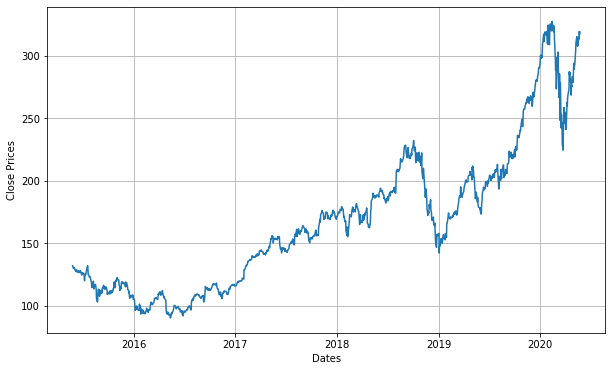

In [13]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df1['close'])
# plt.title('Altaba Inc. closing price')
plt.show()

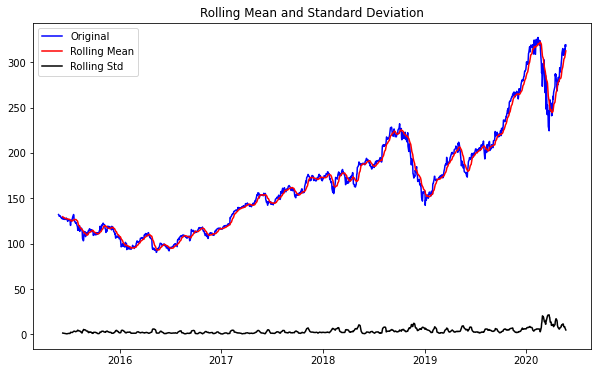

Results of dickey fuller test
Test Statistics                  -0.100130
p-value                           0.949426
No. of lags used                 18.000000
Number of observations used    1239.000000
critical value (1%)              -3.435639
critical value (5%)              -2.863876
critical value (10%)             -2.568013
dtype: float64


In [14]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df1['close'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 720x432 with 0 Axes>

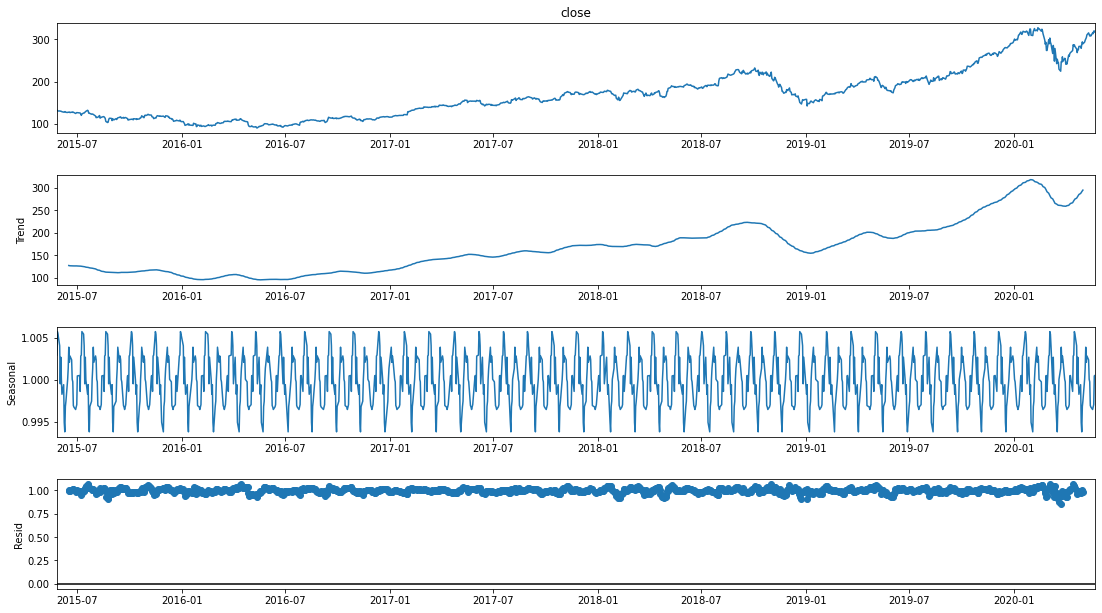

In [15]:
result = seasonal_decompose(df1['close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


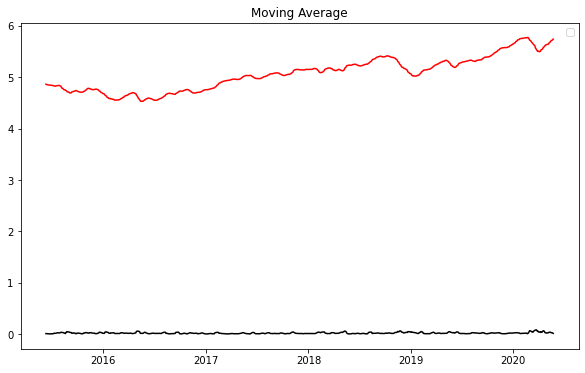

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df1['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
# plt.legend()
plt.show()

In [17]:
df1['stationary'] = df1['close'] - df1['close'].rolling(12).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


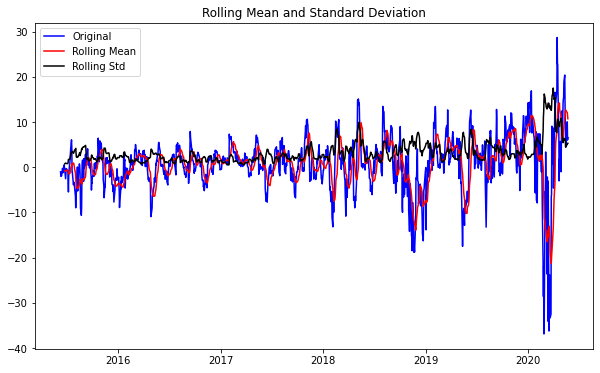

Results of dickey fuller test
Test Statistics               -6.290177e+00
p-value                        3.615396e-08
No. of lags used               1.800000e+01
Number of observations used    1.228000e+03
critical value (1%)           -3.435686e+00
critical value (5%)           -2.863896e+00
critical value (10%)          -2.568025e+00
dtype: float64


In [18]:
test_stationarity(df1['stationary'].dropna())

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


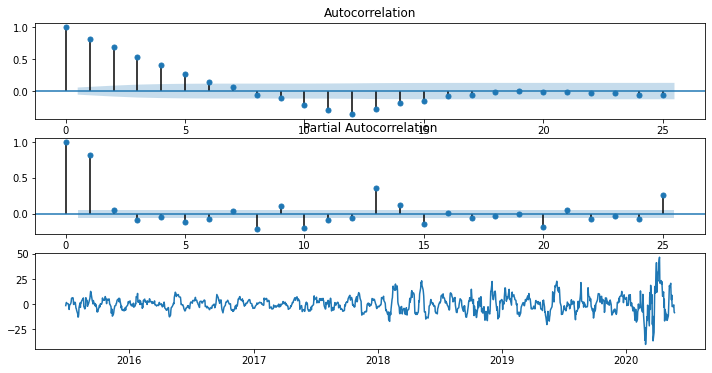

In [20]:
fig, ax = plt.subplots(3, figsize=(12,6))
x = (df1['stationary'].dropna() - df1['stationary'].dropna().shift(12)).dropna()
ax[0] = plot_acf(x, ax=ax[0], lags=25)
ax[1] = plot_pacf(x, ax=ax[1], lags=25)
ax[2].plot(x)

In [22]:
train_data, test_data = df1['close'].iloc[11:int(len(df1['close'])*0.7)] , df1['close'].iloc[int(len(df1['close'])*0.7):] 

In [23]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      max_P = 5,
                      max_D = 5,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3838.353, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3838.835, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3838.619, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3837.131, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3836.257, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3838.840, Time=0.48 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3839.250, Time=0.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3837.622, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3837.230, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3826.187, Time=1.66 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3829.882, Time=1.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3827.046, Time=1.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3840.707, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3840.372, Time=0.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

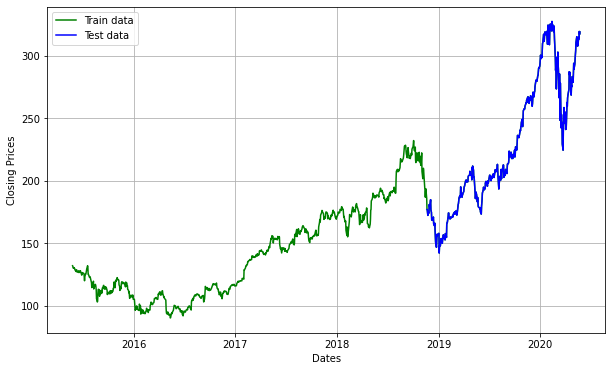

In [24]:
#split data into train and training set
# train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df1['close'], 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

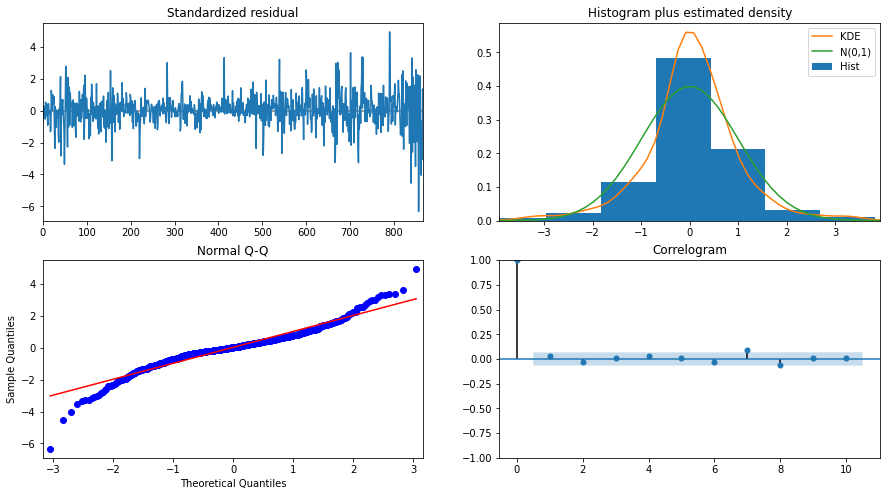

In [25]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [26]:
model = ARIMA(train_data, order=(2, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  868
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1907.093
Method:                       css-mle   S.D. of innovations              2.175
Date:                Mon, 05 Jul 2021   AIC                           3826.187
Time:                        18:23:27   BIC                           3854.784
Sample:                             1   HQIC                          3837.130
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0656      0.072      0.907      0.364      -0.076       0.207
ar.L1.D.close     0.9255      0.008    109.622      0.000       0.909       0.942
ar.L2.D.close    -0.9954      0.005   -1

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


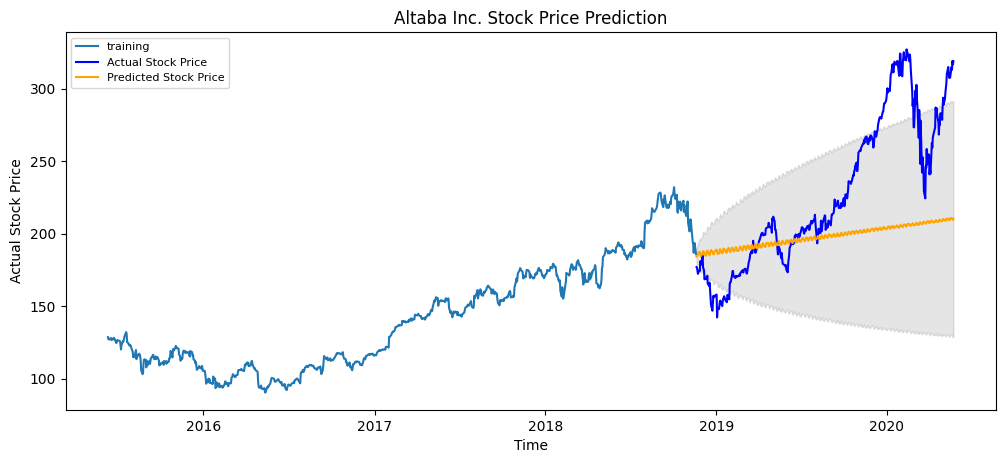

In [27]:
# Forecast
fc, se, conf = fitted.forecast(378, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Altaba Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**LSTM**

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1['close_normalized']=scaler.fit_transform(np.array(df1['close']).reshape(-1,1))
df1['volume_normalized']=scaler.fit_transform(np.array(df1['volume']).reshape(-1,1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [29]:
df1.head()

,close,volume,stationary,close_normalized,volume_normalized
just_date,,,,,
2015-05-27,132.045,45833246,NaN,0.176074,0.228522
2015-05-28,131.780,30733309,NaN,0.174956,0.128419
2015-05-29,130.280,50884452,NaN,0.168623,0.262008
2015-06-01,130.535,32112797,NaN,0.169699,0.137564
2015-06-02,129.960,33667627,NaN,0.167272,0.147872


In [30]:
df2 = df1[['close','volume']].iloc[11:]
# df2['stationary'] = scaler.fit_transform(np.array(df2['stationary']).reshape(-1,1))

In [31]:
train_data, test_data = df1[0:int(len(df1)*0.7)] , df1[int(len(df1)*0.7):] 

In [32]:
test_data

,close,volume,stationary,close_normalized,volume_normalized
just_date,,,,,
2018-11-20,176.98,67825247,-18.790833,0.365786,0.374315
2018-11-21,176.78,31124210,-16.923333,0.364941,0.131010
2018-11-23,172.29,23623972,-18.790000,0.345985,0.081289
2018-11-26,174.62,44998520,-13.515833,0.355822,0.222988
2018-11-27,174.24,41387377,-11.041667,0.354218,0.199049
...,...,...,...,...,...
2020-05-18,314.96,33843125,9.912500,0.948324,0.149035
2020-05-19,313.14,25432385,6.086667,0.940640,0.093277
2020-05-20,319.23,27876215,10.004167,0.966351,0.109478


In [33]:
def create_dataset(dataset, target_col, timestep = 1 ):
  cols = list(dataset.columns)
  dataX, dataY = [],[]
  for i in range(len(dataset) - timestep -1):
    allArrays = np.array([])
    for ele in cols:
      # print(ele)
      a = dataset[ele].iloc[i:(i+timestep)]
      allArrays = np.concatenate([allArrays, a])
      if ele == target_col:
        dataY.append(dataset[ele].iloc[i+timestep])
    dataX.append(allArrays)
  return np.array(dataX), np.array(dataY)

In [34]:
# X,Y = create_dataset(train_data, 'stationary', 3)
time_step = 30
X_train, y_train = create_dataset(train_data[['close_normalized','volume_normalized']], 'close_normalized',time_step)
X_test, y_test = create_dataset(test_data[['close_normalized','volume_normalized']], 'close_normalized',time_step)

In [36]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(849, 60) (849,)
(347, 60) (347,)


In [37]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [38]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [39]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(60,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
14/14 [==============================] - 8s 206ms/step - loss: 0.0385 - val_loss: 0.2152
Epoch 2/50
14/14 [==============================] - 2s 119ms/step - loss: 0.0242 - val_loss: 0.1617
Epoch 3/50
14/14 [==============================] - 2s 122ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 4/50
14/14 [==============================] - 2s 119ms/step - loss: 0.0023 - val_loss: 0.0168
Epoch 5/50
14/14 [==============================] - 2s 117ms/step - loss: 0.0014 - val_loss: 0.0467
Epoch 6/50
14/14 [==============================] - 2s 117ms/step - loss: 0.0012 - val_loss: 0.0258
Epoch 7/50
14/14 [==============================] - 2s 116ms/step - loss: 9.8607e-04 - val_loss: 0.0266
Epoch 8/50
14/14 [==============================] - 2s 117ms/step - loss: 9.6727e-04 - val_loss: 0.0264
Epoch 9/50
14/14 [==============================] - 2s 119ms/step - loss: 9.0569e-04 - val_loss: 0.0234
Epoch 10/50
14/14 [==============================] - 2s 119ms/step - loss: 9.2048e-04 - 

In [42]:
X_std = (train_data['close'] - train_data['close'].min(axis=0)) / (train_data['close'].max(axis=0) - train_data['close'].min(axis=0))
X_scaled = X_std * (max(train_data['close']) - min(train_data['close'])) + min(train_data['close'])

In [43]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [44]:
##Transformback to original form
train_predict_scaled = scaler.inverse_transform(train_predict)
test_predict_scaled = scaler.inverse_transform(test_predict)

In [45]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.02601770805783348

In [46]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

0.09296635476463423

In [47]:
df_plot = pd.DataFrame(df1['close_normalized'])

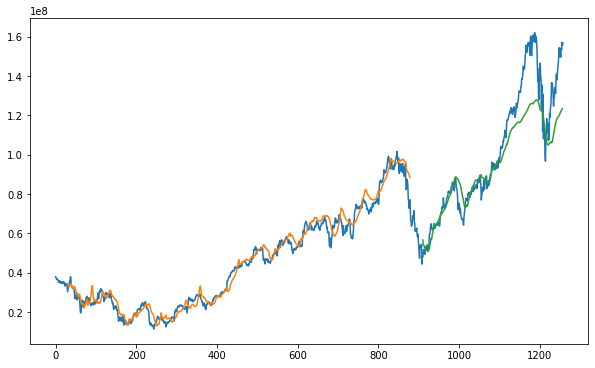

In [48]:
look_back=30
trainPredictPlot = np.empty_like(df_plot)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict_scaled
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_plot)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict_scaled
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df_plot))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()